In [137]:
import sys
sys.path.append("../../../../../src")
import nanonets
import nanonets_utils
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
import numpy as np
import pandas as pd
import networkx as nx

%matplotlib inline

from scipy.optimize import curve_fit
plt.style.use(["science","bright","grid"])
cm  = plt.get_cmap('cividis')

def radius_to_capacitance(np_radius: float)->float:

    factor  = 4*3.14159265359*8.85418781762039*0.001*3.9
    cap     = int(factor*np_radius)

    return cap

In [2]:
topology_parameter  = {
    "Nx"                : 10,
    "Ny"                : 1,
    "Nz"                : 1,
    "e_pos"             : [[0,0,0],[9,0,0]],
    "electrode_type"    : ['constant','constant']
}
sim_class   = nanonets.simulation(topology_parameter, high_C_output=True)
print(sim_class)
# fig, ax     = plt.subplots(dpi=200)
# fig, ax     = nanonets_utils.display_network(sim_class, fig=fig, ax=ax, node_size=80)

Topology Class with 11 particles, 3 junctions.
Network Topology:
[[   1    1 -100 -100]
 [-100    0    2 -100]
 [-100    1    3 -100]
 [-100    2    4 -100]
 [-100    3    5 -100]
 [-100    4    6 -100]
 [-100    5    7 -100]
 [-100    6    8 -100]
 [-100    7    9 -100]
 [-100    8   10 -100]
 [   2    9 -100 -100]]


## DC Input - Capacitance

In [124]:
folder      = "/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/dc_input_vs_cap/"
U_0         = 0.1
t_vals      = np.arange(199999)*1e-10*1e9
cap_vals    = [1e1,1e2,1e3,1e4,1e5,1e6]
data_cap    = {cap : pd.read_csv(f"{folder}Nx=10_Ny=1_Nz=1_Ne=2_{cap}.csv") for cap in cap_vals}
pot_cap     = {cap : pd.read_csv(f"{folder}mean_state_Nx=10_Ny=1_Nz=1_Ne=2_{cap}.csv") for cap in cap_vals}

Text(0.5, 0, '$t$ [ns]')

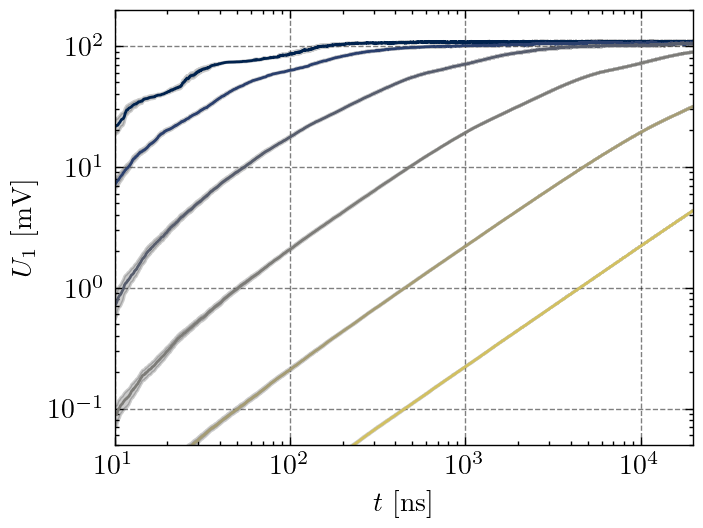

In [158]:
fig = plt.figure(dpi=200, layout='constrained')
ax1 = fig.add_subplot()

for i, (key, df) in enumerate(data_cap.items()):

    y   = df['Current']*1000
    y_e = df['Error']*1000

    ax1.plot(t_vals, y, c=cm(i/len(cap_vals)))
    ax1.fill_between(t_vals, y+y_e, y-y_e, alpha=0.2, color='black')

ax1.set_yscale('log')
ax1.set_ylim(5e-2,2e2)
ax1.set_xscale('log')
ax1.set_xlim(10,np.max(t_vals))
ax1.set_ylabel('$U_1$ [mV]')
ax1.set_xlabel('$t$ [ns]')

Text(0.5, 0, '$t$ [ns]')

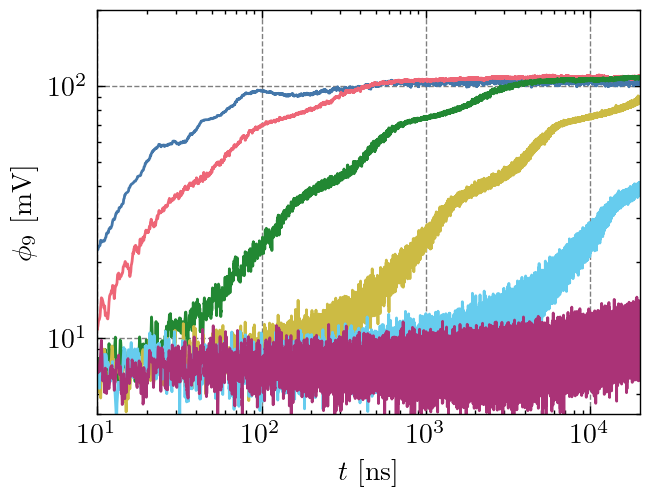

In [162]:
fig = plt.figure(dpi=200)
ax2 = fig.add_subplot()

for i, (key, df) in enumerate(data_cap.items()):

    p   = pot_cap[key]['9']*1000
    ax2.plot(t_vals, p)

ax2.set_yscale('log')
ax2.set_ylim(5e0,2e2)
ax2.set_xscale('log')
ax2.set_xlim(10,np.max(t_vals))
ax2.set_ylabel('$\phi_9$ [mV]')
ax2.set_xlabel('$t$ [ns]')

In [109]:
t_at_68 = []

for key, df in data_cap.items():

    t_at_68.append(t_vals[np.where(df['Current'].values > 0.068)[0][0]])

IndexError: index 0 is out of bounds for axis 0 with size 0

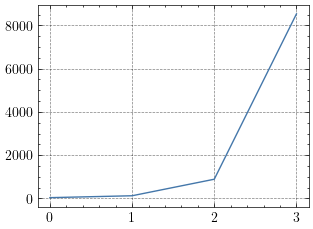

In [111]:
plt.plot(t_at_68)

In [151]:
def exp_saturation(x, tau, a0):
    return a0*(1 - np.exp(-x/tau))
def stretched_exp_saturation(x, tau, beta, a0):
    return a0*(1 - np.exp(-(x/tau)**beta))
def power_law_saturation(x, tau, beta, a0):
    return a0*(1 - (x/tau)**(-beta))
def double_exp_saturation(x, tau1, tau2, a1, a2):
    return a1*(1 - np.exp(-x/tau1)) + a2*(1 - np.exp(-x/tau2))
def hyperbolic_saturation(x, tau, a0):
    return a0*(1 - 1/(1+x/tau))
def log_saturation(x, tau, a0):
    return a0*(1 - 1/np.log(1+x/tau))
def modified_exp_saturation(x, tau1, tau2, a1, a2):
    return a1*(1-np.exp(-x/tau1)) + a2*np.exp(-x/tau2)
def logistic_function(x, tau, a0, x0):
    return a0 / (1 + np.exp(-(x-x0)/tau))
def generalized_logistic_function(x, tau, a0, x0, nu1, nu2):
    return a0 / ((1 + nu1*np.exp(-(x-x0)/tau))**(1/nu2))
def exp_power_law_saturation(x, tau1, tau2, alpha, beta, a0):
    return a0*(1 - np.exp(-(x/tau1)**alpha))*(1 + x/tau2)**(-beta)

/tmp/ipykernel_29226/3010679329.py:20: RuntimeWarning: invalid value encountered in power
  return a0*(1 - np.exp(-(x/tau1)**alpha))*(1 + x/tau2)**(-beta)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.

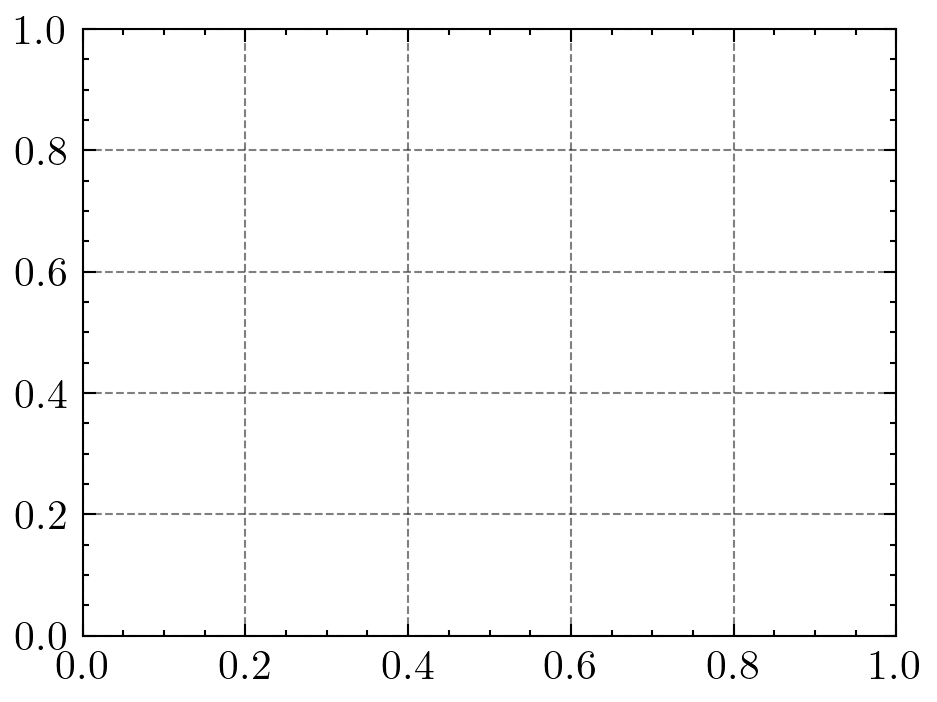

In [153]:
params  = []
stds    = []
func    = exp_power_law_saturation
p0      = [100, 1, 100]

fig = plt.figure(dpi=300)
ax  = fig.add_subplot()

for i, (key, df) in enumerate(data_cap.items()):

    y   = df['Current']*1000
    p,c = curve_fit(func, t_vals, y, maxfev=2000, p0=[key, 10, 1, 1, 1])
    pl  = ax.plot(t_vals, y, '.', ms=1)
    ax.plot(t_vals, func(t_vals, *p), c=pl[0].get_color())

    params.append(p)
    stds.append(np.sqrt(c[0,0]))

    print(p)

# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-5,1e3)
ax.set_xlim(0,50)
ax.set_ylabel('$U_1$ [mV]')
ax.set_xlabel('$t$ [ns]')